In [26]:
import xarray as xr
import pandas as pd
import numpy as np
from pathlib import Path
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
import os
if os.getcwd().split('/')[-1] != "vegetation_health":
    os.chdir('..')
    
assert os.getcwd().split('/')[-1] == "vegetation_health", f"Working directory should be the root (), currently: {os.getcwd()}"

In [24]:
from predictor.analysis.plot_results import create_dataset_from_vars, plot_results
from predictor.analysis.utils import load_model_data

In [127]:
def drop_nans_and_flatten(dataArray):
    """flatten the array and drop nans from that array. Useful for plotting histograms.

    Arguments:
    ---------
    : dataArray (xr.DataArray)
        the DataArray of your value you want to flatten
    """
    # drop NaNs and flatten
    return dataArray.values[~np.isnan(dataArray.values)]


# Initialise the Paths and read in the data

In [12]:
data_dir = Path('./data')
processed_data=Path('data/processed')

normalising_dict_path = data_dir / "processed" / "normalizing_dict.json"
test_dir = processed_data / "ndvi"/"arrays"/"test"
train_dir = processed_data / "ndvi"/"arrays"/"train"
predictions_path = processed_data/"ndvi"/"arrays"/"preds.npy"

In [68]:
# read the predictions
preds = np.load(predictions_path)
true = np.load(processed_data / "ndvi" / 'arrays/test/y.npy')


In [22]:
# read in data that is fed through the models (train/test)
train_data = load_model_data("train")
test_data = load_model_data("test")

In [17]:
# create a xr.Dataset object
preds_xr = create_dataset_from_vars(preds, test_data.latlon, "preds", to_xarray=True)
true_xr = create_dataset_from_vars(true, test_data.latlon, "true", to_xarray=True)
ds = preds_xr.merge(true_xr)


In [20]:
difference = ds.true - ds.preds
da = xr.DataArray(difference, coords=[ds.lat, ds.lon], dims=['lat','lon'])
diff = da.to_dataset('difference')
ds = ds.merge(diff)

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
ds

<xarray.Dataset>
Dimensions:     (lat: 404, lon: 368)
Coordinates:
  * lat         (lat) float64 -4.975 -4.925 -4.875 -4.825 ... 15.07 15.12 15.17
  * lon         (lon) float64 32.62 32.68 32.72 32.77 ... 50.88 50.93 50.97
Data variables:
    preds       (lat, lon) float32 0.53142864 0.51000357 0.50388175 ... nan nan
    true        (lat, lon) float64 0.5559 0.5136 0.4928 0.4576 ... nan nan nan
    difference  (lat, lon) float64 0.02447 0.003596 -0.01108 ... nan nan nan

# Explore the output of the models

In [45]:
colors = sns.color_palette()

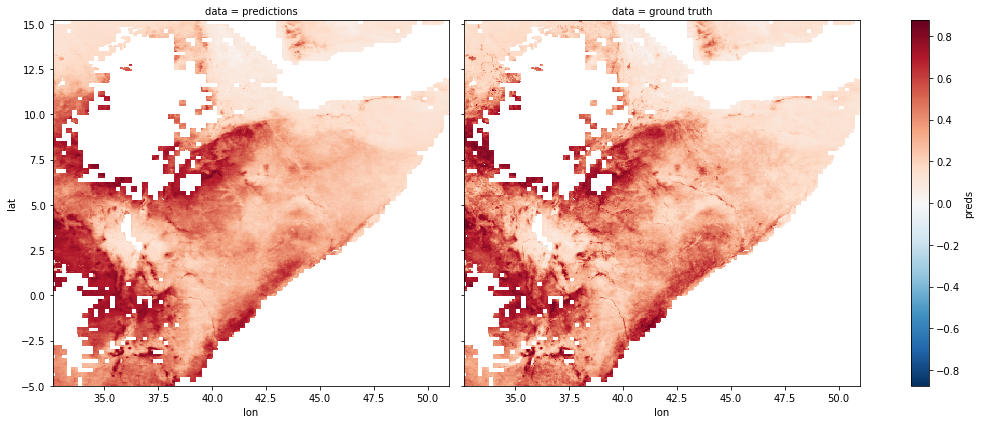

In [25]:
plot_results()

Text(0.5, 1.0, 'Distribution of Actual NDVI')

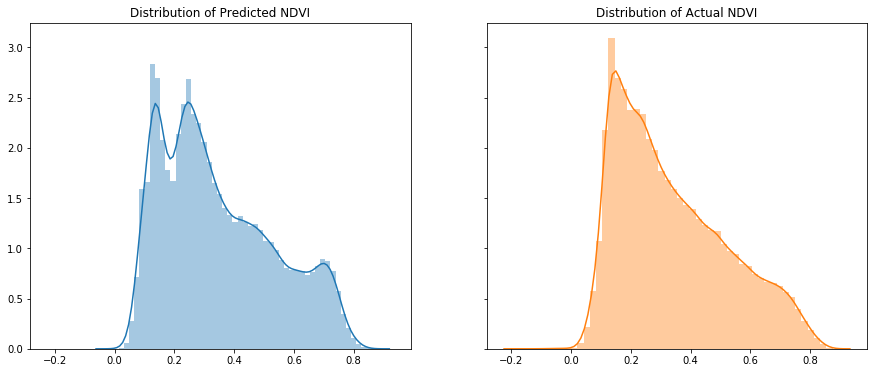

In [46]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True,figsize=(15,6))
sns.distplot(preds, ax=ax1)
ax1.set_title('Distribution of Predicted NDVI')
sns.distplot(test_data.y, ax=ax2,color=colors[1])
ax2.set_title('Distribution of Actual NDVI')

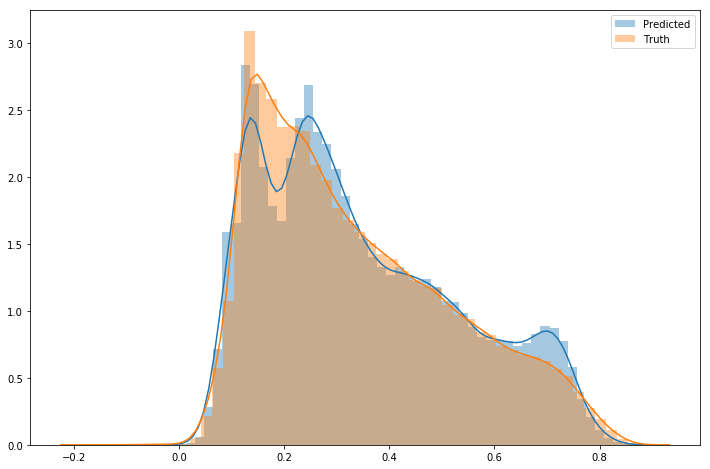

In [48]:
fig,ax=plt.subplots(figsize=(12,8))
sns.distplot(preds,ax=ax, label="Predicted")
sns.distplot(test_data.y,ax=ax, label="Truth")
plt.legend();

In [41]:
print(f"Minimums  True: {min(true)} Predicted: {min(preds)}")
print(f"Maximums  True: {max(true)} Predicted: {max(preds)}")

Minimums  True: -0.16679999232292175 Predicted: -0.0035918354988098145
Maximums  True: 0.8747999668121338 Predicted: 0.8604661822319031


## Analysis of Low NDVI (poor growing conditions)

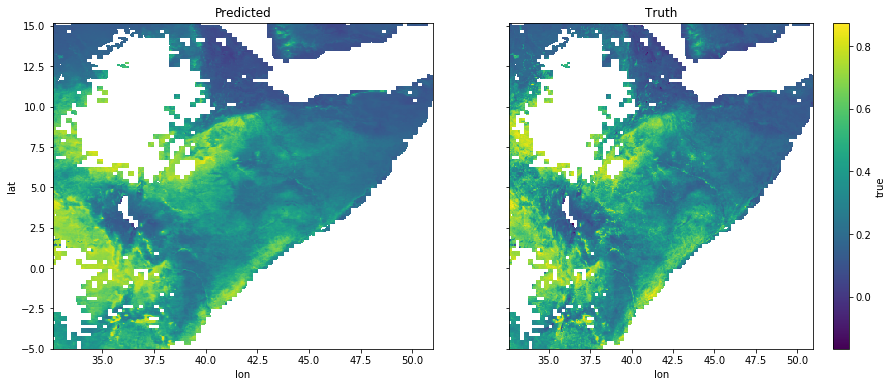

In [144]:

def plot_spatial_preds_vs_true(ds, cmap='viridis'):
    """plot the spatial patterns of the predicted vs. true values
    
    TODO: Make them take up the same space (colorbar means that predicted is bigger)
    """
    fig, (ax1,ax2) = plt.subplots(1,2,sharex=True, sharey=True, figsize=(15,6))
    
    # get the colorbar min/max from the values in the `ds` object
    max_ = max(
        max(drop_nans_and_flatten(ds.preds)),
        max(drop_nans_and_flatten(ds.true))
    )
    min_ = min(
        min(drop_nans_and_flatten(ds.preds)),
        min(drop_nans_and_flatten(ds.true))
    #    ds.preds.min().values,ds.true.min().values
    )
    kwargs = {'vmin':min_,'vmax':max_,'cmap':cmap}
    
    ds.preds.plot(ax=ax1, add_colorbar=False,**kwargs)
    ax1.set_title('Predicted')
    ds.true.plot(ax=ax2, add_colorbar=True,**kwargs)
    ax2.set_title('Truth')
    ax2.set_ylabel('')
    
    return fig,(ax1,ax2)
    
plot_spatial_preds_vs_true(ds);

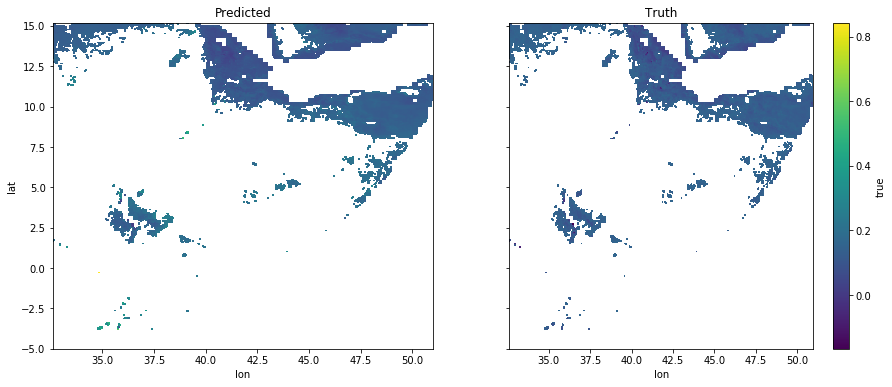

In [147]:
low_ndvi_thresh = np.quantile(true, 0.2)

low = ds.where(ds.true < low_ndvi_thresh)
plot_spatial_preds_vs_true(low);

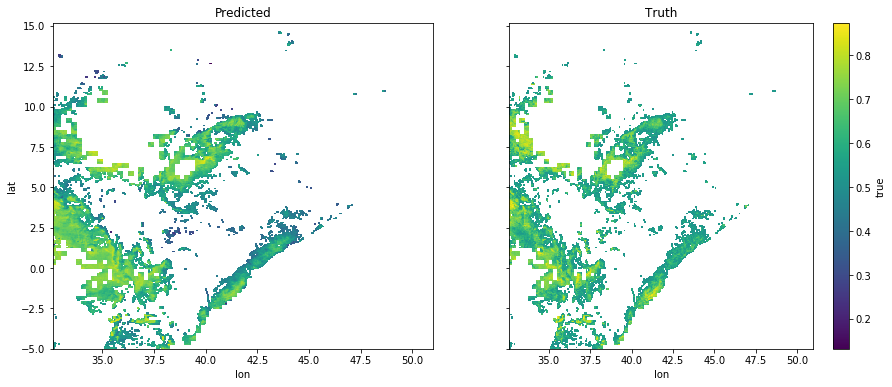

In [148]:
high_ndvi_thresh = np.quantile(true, 0.8)

high = ds.where(ds.true > high_ndvi_thresh)
plot_spatial_preds_vs_true(high);

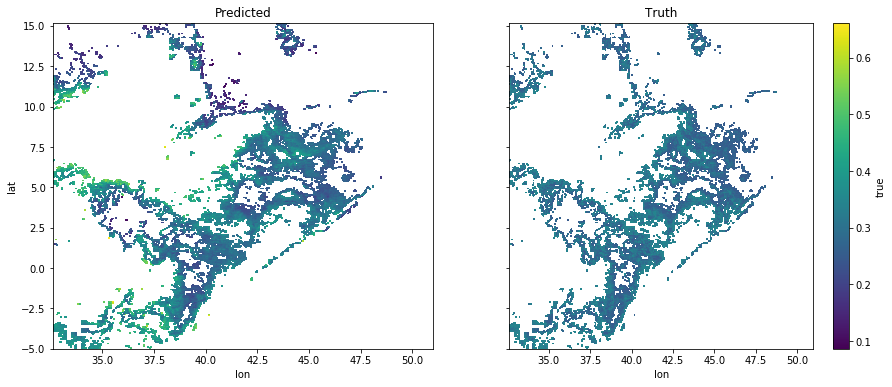

In [154]:
mid_upper_thresh = np.quantile(true, 0.6)
mid_lower_thresh = np.quantile(true, 0.4)

mid = ds.where((ds.true > mid_lower_thresh) & (ds.true < mid_upper_thresh))
plot_spatial_preds_vs_true(mid);

In [157]:
mid.dropna(['lat','lon'])

TypeError: unhashable type: 'list'

Text(0.5, 1.0, 'HIGH NDVI Values (Where true > q=0.8)')

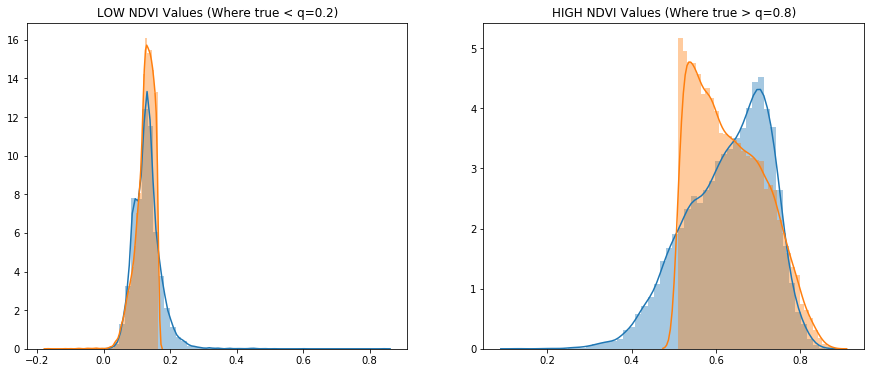

In [151]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(15,6))
sns.distplot(drop_nans_and_flatten(low.preds),ax=ax1,label='Predicted')
sns.distplot(drop_nans_and_flatten(low.true),ax=ax1,label='Truth')
ax1.set_title('LOW NDVI Values (Where true < q=0.2)')
sns.distplot(drop_nans_and_flatten(high.preds),ax=ax2,label='Predicted')
sns.distplot(drop_nans_and_flatten(high.true),ax=ax2,label='Truth')
ax2.set_title('HIGH NDVI Values (Where true > q=0.8)')

In [77]:
p_sort = preds.copy()
p_sort.sort()
t_sort = true.copy()
t_sort.sort()

In [82]:
def split_into_quantiles(arr):
    """split the array into quantiles 
    ([0-0.2],[0.2-0.4],[0.4-0.6],[0.6-0.8],[0.8-1.0])
    """
    qrt_0 = len(arr)*0.2
    
    return




82252

82252